In [17]:
from TimeSeries_impact import utilities, ts_analysis, impact, plot_functions

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

from imp import reload

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create dataset

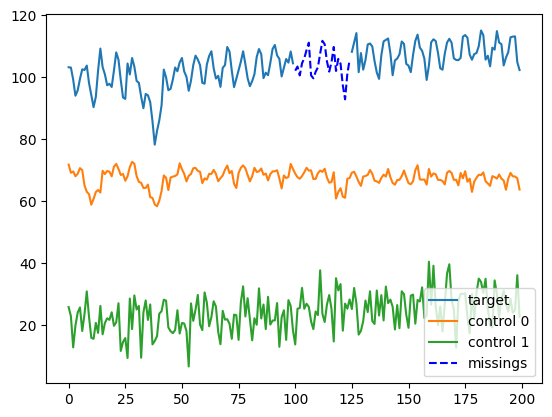

In [18]:
# create fake data where the control has the same underlying seasonal component as target
reload(utilities)
ts = utilities.make_time_serie(200, freq=[7], nbr_rand_event=5) # dict with keys = ['obs', 'control', 'rand_event', 'season', 'base']

# make dataframe
data = pd.DataFrame()
data["target"] = ts["obs"]
for i in range(len(ts["control"])):
    data[f"control {i}"] = ts["control"][i]

# add some missing data in the target time series
without_missing = data["target"].copy()
data["target"][100:125] = np.nan

data.plot()
plt.plot(without_missing[100:125], color="blue", linestyle="dashed", label="missings")
plt.legend()
plt.show()


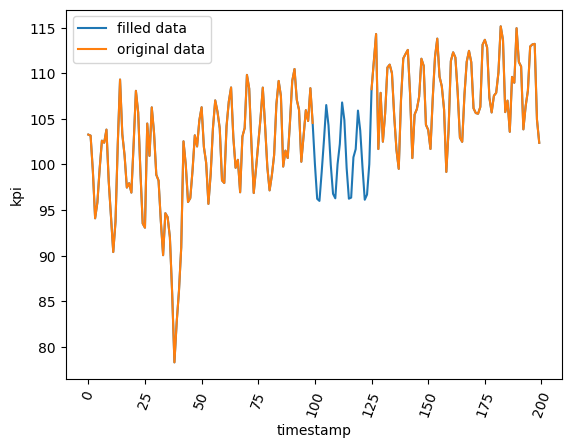

In [19]:
# Fill in data gap

data["target"] = ts_analysis.fill_data(data, inplace=False, plot=True)

# Time series analysis

In [4]:
# create TSA object
reload(ts_analysis)
TSA = ts_analysis.TSA(data)

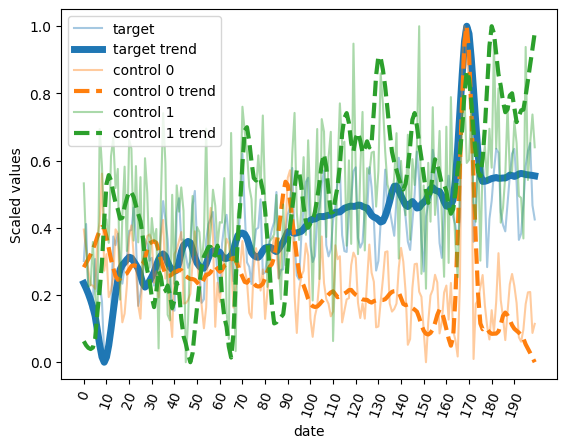

In [5]:
# plot scaled trend component along with scaled raw data
TSA.plot()

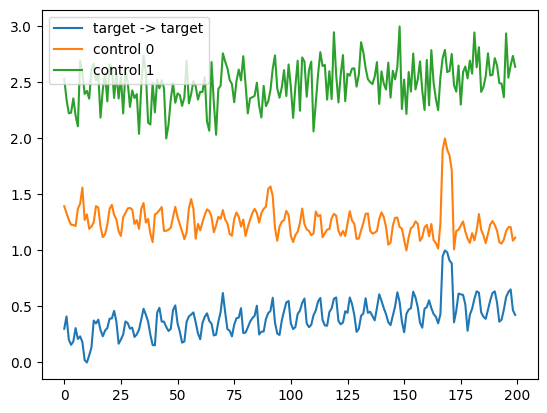

In [6]:
# check normalized and shifted ts to look for data gaps
TSA.plot_scaled_view()

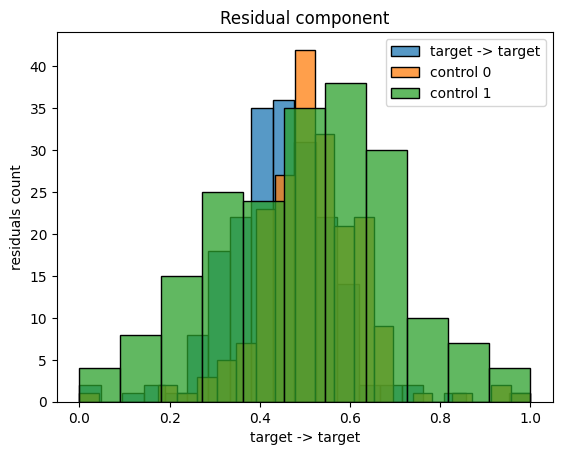

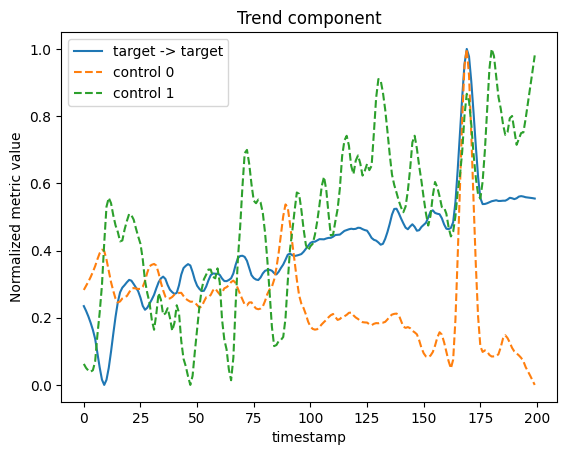

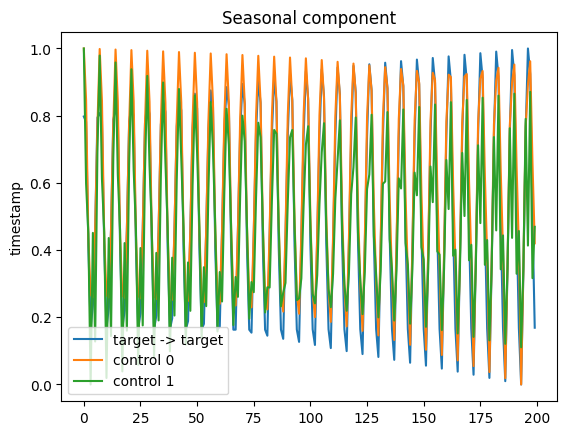

In [7]:

# plot component from decomposition

TSA.plot()
TSA.plot_component()

In [8]:
# analyse the similarity of the components
# To use the trend instead of the raw data for the causal impact analysis, the components must be very similar

print()
print("Analysis results")
res_res, res_seas = TSA.analyze()
corr = TSA.correlation()

print()
print("Similarity of residuals")
print(res_res)

print()
print("Similarity of seasonality")
print(res_seas)

print()
print("Correlation of the time series")
print(corr)


Analysis results

Similarity of residuals
                             control 0  control 1
Bhattacharyya Distance        0.044345   0.068462
Kullback-Leibler Divergence   0.183822   0.207385
Hellinger Distance            0.208269   0.257237
Wasserstein Distance          0.070911   0.091806
Kolmogorov test               0.305000   0.305000

Similarity of seasonality
   control 0  control 1
0   0.979395   0.830704

Correlation of the time series
(                  target -> target  control 0  control 1
target -> target          1.000000   0.478457   0.438427
control 0                 0.478457   1.000000   0.110684
control 1                 0.438427   0.110684   1.000000,                   target -> target  control 0  control 1
target -> target          1.000000   0.252371   0.447766
control 0                 0.252371   1.000000   0.033835
control 1                 0.447766   0.033835   1.000000,                   target -> target  control 0  control 1
target -> target          1.000000

# Simulation and power analysis

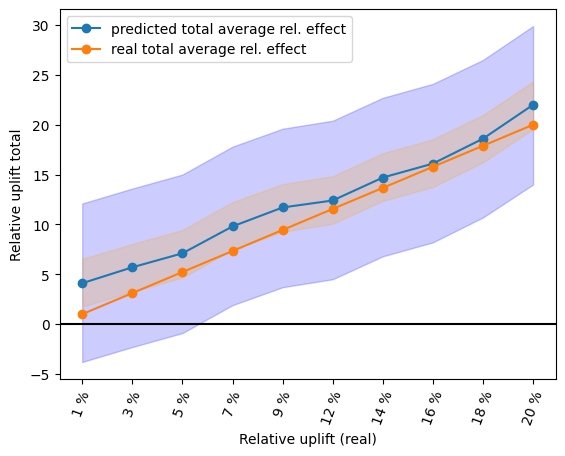

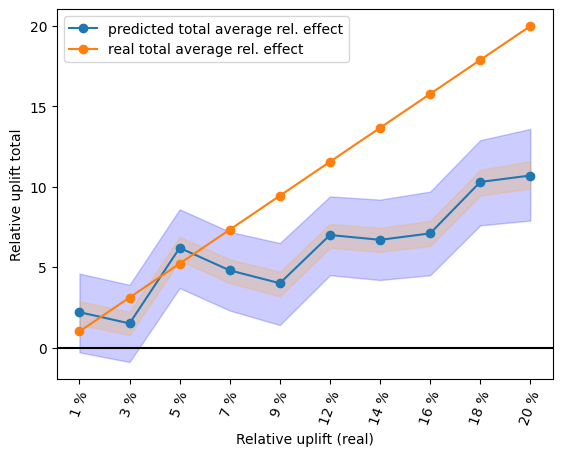

In [9]:
# perform simulation to get "power" of the model

impact_class = impact.SimImpact(data)

# single simulation on raw data
relup = np.linspace(0.01, 0.2, 10)
impact_class.make_sim(relup_list=relup, test_size=14)
fig = impact_class.plot_sim_rel()
display(fig)

# single simulation on trend data
relup = np.linspace(0.01, 0.2, 10)
impact_class.make_sim(relup_list=relup, test_size=14, on_trend=True)
fig = impact_class.plot_sim_rel()
display(fig)


Keys dict_keys(['0.0100', '0.0311', '0.0522', '0.0733', '0.0944', '0.1156', '0.1367', '0.1578', '0.1789', '0.2000'])


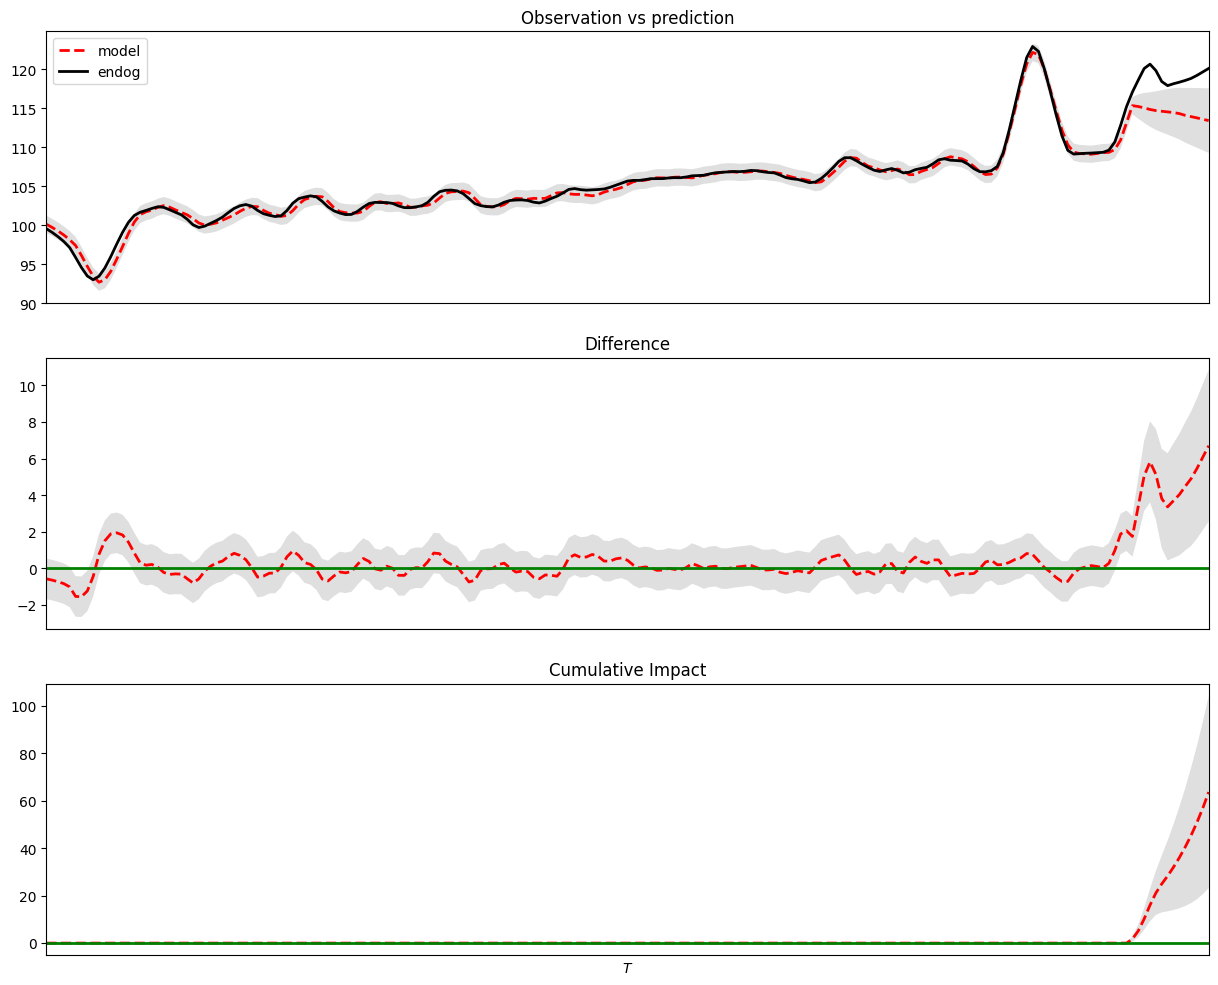

In [10]:
# check single causalimpact results with relup as keys
print("Keys", impact_class.res_sim.keys())
impact_class.res_sim['0.0944'][1].plot()

Starting simulation


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


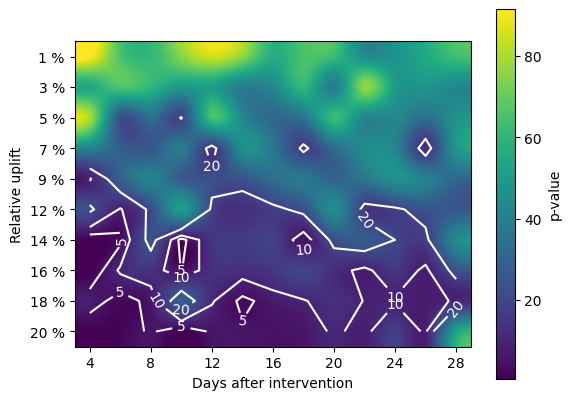

In [8]:
# power analysis by looping over different pre- and post- period lengths

_ = impact_class.power_analyse(relup_list=relup)
fig_power = impact_class.plot_power(alpha=[5,10,20])
display(fig_power)

# Classic causal impact with BSTS

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    116.62             5830.98
Prediction (s.d.)         104.18 (0.95)      5208.84 (47.51)
95% CI                    [102.24, 105.96]   [5111.79, 5298.01]

Absolute effect (s.d.)    12.44 (0.95)       622.14 (47.51)
95% CI                    [10.66, 14.38]     [532.97, 719.19]

Relative effect (s.d.)    11.94% (0.91%)     11.94% (0.91%)
95% CI                    [10.23%, 13.81%]   [10.23%, 13.81%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 116.62. By contrast, in the absence of an
intervention, we would have expected an average response of 104.18.
The 95% interval of this counterfactual prediction is [102.24, 105.96].
Subtracting this prediction 

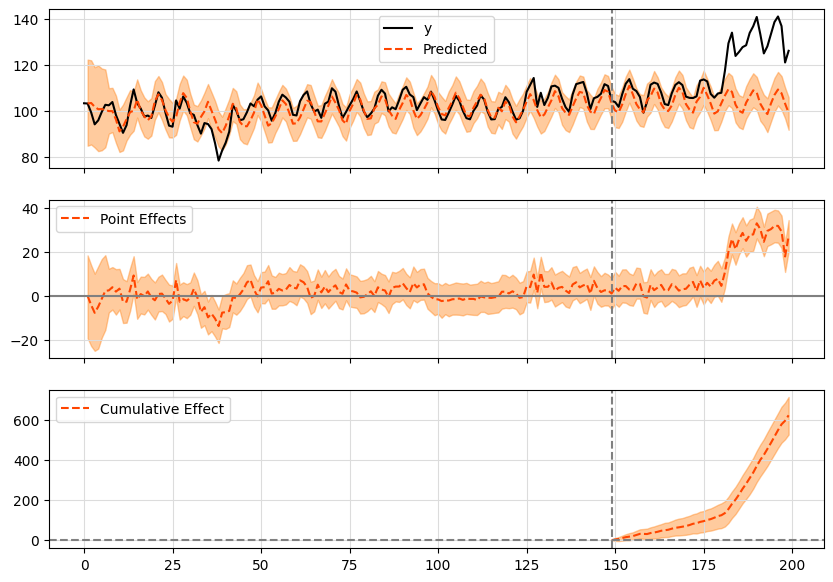

In [20]:
# perform classic causalimpact with tfcausalimpact

# add effect
relup = 0.2
uplift = relup*np.mean(data["target"])
data["target"] = utilities.add_effect(data["target"], uplift, 50)

pre_period = [0, 149]
post_period = [150, 199]

ci = impact.CausalImpact(data, pre_period, post_period, model_args={"nseasons":7})
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()
